In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import shapely
import folium
import pyproj

**Load the data**

In [2]:
# function runs in approx. 85 minutes to extract 70145 rows
def extract_metingen(n):
    data = pd.DataFrame()
    
    for i in tqdm(range(1, n+1)):
        pull = requests.get(f'https://api.data.amsterdam.nl/meetbouten/meting/?page={i}').json()

        for j, item in enumerate(pull['results']):
            link = item['_links']['self']['href']
            pull2 = requests.get(link).json()
            del pull2['_links'], pull2['referentiepunt']
            pull_df = pd.DataFrame(pull2, index=[j])
            data = data.append(pull_df)
            
    return data

In [3]:
# function runs in approx. 17 minutes to extract 12937 rows
def extract_meetbouten(n):
    data = pd.DataFrame()
    
    for i in tqdm(range(1, n+1)):
        pull = requests.get(f'https://api.data.amsterdam.nl/meetbouten/meetbout/?page={i}').json()

        for j, item in enumerate(pull['results']):
            link = item['_links']['self']['href']
            pull2 = requests.get(link).json()
            del pull2['_links'], pull2['metingen'], pull2['geometrie']
            pull_df = pd.DataFrame(pull2, index=[j])
            data = pd.concat([data, pull_df])
            
    return data

In [4]:
meetbout_df = extract_meetbouten(518)
meetbout_df

100%|████████████████████████████████████████████████████████████████████████████████| 518/518 [16:53<00:00,  1.96s/it]


,_display,meetboutidentificatie,buurt,x_coordinaat,y_coordinaat,hoogte_nap,zakking_cumulatief,datum,bouwblokzijde,eigenaar,...,stadsdeel_link,adres,locatie,zakkingssnelheid,status,bouwblok,bouwblok_link,blokeenheid,rollaag,dataset
0,10181000 (omg. Orteliusstraat 190),10181000,EK02,118370.00,487046.00,1.6394,32.7000000000000,1986-12-24,,,...,https://api.data.amsterdam.nl/gebieden/stadsde...,Orteliusstraat 190,(def.meting Sloten 3832 ; x uit portiek 192),1.1000000000000,actueel,BB38,https://api.data.amsterdam.nl/gebieden/bouwblo...,0,None,meetbouten
1,10181001 (omg. Jan Evertsenstraat 150),10181001,EK02,118382.00,487042.00,1.8775,31.6000000000000,1986-12-24,,,...,https://api.data.amsterdam.nl/gebieden/stadsde...,Jan Evertsenstraat 150,(def.meting Sloten 3832 ; uit deurpost),1.1000000000000,actueel,BB38,https://api.data.amsterdam.nl/gebieden/bouwblo...,0,None,meetbouten
2,10181002 (omg. Hoofdweg 308),10181002,EK03,118435.00,487095.00,1.2638,8.6000000000000,1986-12-24,,,...,https://api.data.amsterdam.nl/gebieden/stadsde...,Hoofdweg 308,(def.meting Sloten 3832),1.3000000000000,actueel,BB41,https://api.data.amsterdam.nl/gebieden/bouwblo...,0,None,meetbouten
3,10181003 (omg. Mercatorstraat 1A),10181003,EK03,118484.00,487090.00,1.3511,2.3000000000000,1986-12-24,,,...,https://api.data.amsterdam.nl/gebieden/stadsde...,Mercatorstraat 1A,(def.meting Sloten 3832 ; in pilaar),0.3000000000000,actueel,BB41,https://api.data.amsterdam.nl/gebieden/bouwblo...,0,None,meetbouten
4,10181004 (omg. Mercatorstraat 2/4),10181004,EK03,118492.00,487092.00,1.3969,5.4000000000000,1986-12-24,,,...,https://api.data.amsterdam.nl/gebieden/stadsde...,Mercatorstraat 2/4,(def.meting Sloten 3832 ; in pilaar),0.8000000000000,actueel,BB46,https://api.data.amsterdam.nl/gebieden/bouwblo...,0,None,meetbouten
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,26281043 (omg. Gedempt Hamerkanaal 199/207),26281043,NP01,123214.90,488424.50,2.5454,2.2000000000000,1988-01-11,,,...,https://api.data.amsterdam.nl/gebieden/stadsde...,Gedempt Hamerkanaal 199/207,(Spijkerhaven pakje K 1468),0.4000000000000,actueel,NF06,https://api.data.amsterdam.nl/gebieden/bouwblo...,0,None,meetbouten
8,26281044 (omg. Gedempt Hamerkanaal 199/207),26281044,NP01,123220.90,488396.20,2.4507,0.9000000000000,1988-01-11,,,...,https://api.data.amsterdam.nl/gebieden/stadsde...,Gedempt Hamerkanaal 199/207,(Spijkerhaven pakje K 1468),0.1000000000000,actueel,NF06,https://api.data.amsterdam.nl/gebieden/bouwblo...,0,None,meetbouten
9,26381000 (omg. Javakade 21 in ronding),26381000,MA01,124267.00,487759.50,2.4649,0.0000000000000,1992-08-10,,,...,https://api.data.amsterdam.nl/gebieden/stadsde...,Javakade 21 in ronding,(def. meting),0.0000000000000,actueel,CK09,https://api.data.amsterdam.nl/gebieden/bouwblo...,0,None,meetbouten
10,26381001 (omg. Javakade 21 in ronding),26381001,MA01,124275.40,487782.80,2.4636,0.0000000000000,1992-08-10,,,...,https://api.data.amsterdam.nl/gebieden/stadsde...,Javakade 21 in ronding,(def. meting),0.0000000000000,actueel,CK09,https://api.data.amsterdam.nl/gebieden/bouwblo...,0,None,meetbouten


**Preprocess the data**

In [5]:
meetbout_df = meetbout_df.reset_index()[['meetboutidentificatie', 'x_coordinaat', 'y_coordinaat', 'hoogte_nap', 'zakking_cumulatief', 'datum', 'zakkingssnelheid']]
meetbout_df[['x_coordinaat', 'y_coordinaat', 'hoogte_nap', 'zakking_cumulatief', 'zakkingssnelheid']] = meetbout_df[['x_coordinaat', 'y_coordinaat', 'hoogte_nap', 'zakking_cumulatief', 'zakkingssnelheid']].astype(float)
meetbout_df['datum'] = pd.to_datetime(meetbout_df['datum'])

In [9]:
meetbout_df

,meetboutidentificatie,x_coordinaat,y_coordinaat,hoogte_nap,zakking_cumulatief,datum,zakkingssnelheid
0,10181000,118370.0,487046.0,1.6394,32.7,1986-12-24,1.1
1,10181001,118382.0,487042.0,1.8775,31.6,1986-12-24,1.1
2,10181002,118435.0,487095.0,1.2638,8.6,1986-12-24,1.3
3,10181003,118484.0,487090.0,1.3511,2.3,1986-12-24,0.3
4,10181004,118492.0,487092.0,1.3969,5.4,1986-12-24,0.8
...,...,...,...,...,...,...,...
12932,26281043,123214.9,488424.5,2.5454,2.2,1988-01-11,0.4
12933,26281044,123220.9,488396.2,2.4507,0.9,1988-01-11,0.1
12934,26381000,124267.0,487759.5,2.4649,0.0,1992-08-10,0.0
12935,26381001,124275.4,487782.8,2.4636,0.0,1992-08-10,0.0


In [7]:
meetbout_df.to_csv('../Data/Meetbouten.csv', index=True)

TO DO: Save dataframe as csv

**EDA**

Covers:
- How many unique measuring bolts?
- Histograms
    - 'zakking_cumulatief'
    - 'zakkingssnelheid'
    - 'hoogte_nap'
- How many measuring bolts have only one measurement?
    - TO DO: bouten met 0.0 zakkingssnelheid en 0.0 zakking_cumulatief hoeven hier niet per se onder te vallen!
- What is the timespan of the measurements?
- Geographical visualisation of the data points


In [22]:
# number of unique measuring bolts
len(meetbout_df['meetboutidentificatie'].unique())

12937

Text(0.5, 1.0, 'Histogram of Cumulative Subsidence')

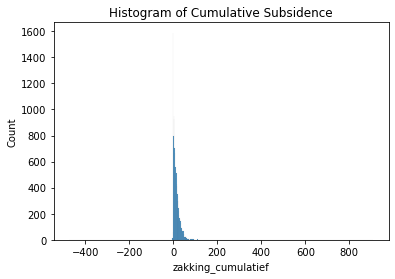

In [23]:
sns.histplot(meetbout_df['zakking_cumulatief']) 
plt.title("Histogram of Cumulative Subsidence")

Text(0.5, 1.0, 'Histogram of Subsidence Speed')

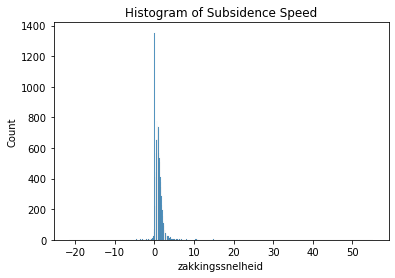

In [24]:
sns.histplot(meetbout_df['zakkingssnelheid']) 
plt.title("Histogram of Subsidence Speed")

Text(0.5, 1.0, 'Histogram of Height compared to NAP')

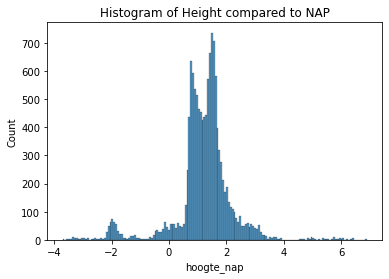

In [25]:
sns.histplot(meetbout_df['hoogte_nap']) 
plt.title("Histogram of Height compared to NAP")

In [26]:
# measuring bolts that have only one measurement
enkele_meting = meetbout_df[meetbout_df['zakkingssnelheid'] == meetbout_df['zakking_cumulatief']]['meetboutidentificatie']
len(enkele_meting)

1294

In [27]:
# time span of the measurements
meetbout_df['datum'] = pd.to_datetime(meetbout_df['datum'])
meetbout_df['datum'].min().date(), meetbout_df['datum'].max().date()

(datetime.date(1948, 11, 13), datetime.date(2021, 9, 20))

In [28]:
# creating GeoDataFrame based on coordinates
gdf = gpd.GeoDataFrame(meetbout_df, geometry=gpd.points_from_xy(meetbout_df['x_coordinaat'], meetbout_df['y_coordinaat']))

# translating coordinate projection to projection matching folium map
gdf.crs = "EPSG:28992"
gdf = gdf.to_crs("EPSG:4326")
gdf.head()

,meetboutidentificatie,x_coordinaat,y_coordinaat,hoogte_nap,zakking_cumulatief,datum,zakkingssnelheid,geometry
0,10181000,118370.0,487046.0,1.6394,32.7,1986-12-24,1.1,POINT (4.84935 52.37007)
1,10181001,118382.0,487042.0,1.8775,31.6,1986-12-24,1.1,POINT (4.84953 52.37004)
2,10181002,118435.0,487095.0,1.2638,8.6,1986-12-24,1.3,POINT (4.85030 52.37052)
3,10181003,118484.0,487090.0,1.3511,2.3,1986-12-24,0.3,POINT (4.85102 52.37047)
4,10181004,118492.0,487092.0,1.3969,5.4,1986-12-24,0.8,POINT (4.85114 52.37049)


In [14]:
# create folium map centered on Amsterdam
hmap = folium.Map(location=[52.3676, 4.90], zoom_start=12, tiles='OpenStreetMap')
labels = folium.FeatureGroup("Locations")

# extract coordinates of datapoints
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in gdf.geometry]

# iterate over coordinates
for i, coordinates in enumerate(geo_df_list):
    
    # add markers for datapoints
    hmap.add_child(
        folium.Marker(
            location = coordinates,
            popup =
                "Meting: " + str(gdf['meetboutidentificatie'][i]) + "<br>"
                + "Datum: " + str(gdf['datum'][i].date()) + "<br>"
                + "Zakkingssnelheid: " + str(gdf['zakkingssnelheid'][i]) + "<br>"
                + "Zakking Cumulatief: " + str(gdf['zakking_cumulatief'][i]),
                icon=folium.Icon(color='green'),
            )
    )

hmap
